In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import statsmodels.api as sm
import scipy
import matplotlib as mpl


%matplotlib widget
plt.style.use('presentation.mplstyle')


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
all_analysis_folders = get_analysis_folders()
path_figure = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\HFSP_symbiotic-networks\Article_TravellingWave\Figure5\PlotsCorentin"
plates = [
    "52_20220707",
    "56_20220701",
    "59_20201126",
    "69_20201119",
    "76_20210108",
    "81_20220704",
    "84_20220621",
    "94_20201123",
    "102_20201226",
    "152_20201224",
    "792_20210915",
    "1076_20220511",
    "941_20220404"
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,use_saved=False)
time_plate_info['day'] = (time_plate_info["time_since_begin_h"]/24).astype(int)
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_new"
paths = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
table = pd.DataFrame()
num_day = 3
for path in paths:
    new= pd.read_csv(os.path.join(path_root,path))
    new['csv_id'] = path
    table = pd.concat([table,new])
table["days"] = table["time_since_crossing"] / pd.Timedelta(days=1)
table["3days"] = (table["time_since_crossing"] / pd.Timedelta(days=num_day)).astype(int)
table["days_since_first_image"] = table["days"] - table.groupby("unique_id")[
    "days"
].transform("min")
table["abs_speed-"] = -table["speed-"]

table["speed"] = table[["speed+", "abs_speed-"]].max(1)
grouping = 1
table["lengthdm"] = (np.log2((table["tot_length"]))/grouping).astype(int) * grouping
table["log_tot_num_spores"] = (np.log2((table["tot_num_spore"]))/grouping).astype(int)* grouping
table["log_tot_num_spores"] = (np.log10((table["tot_num_spore"])))

grouping = 1
funtype = 1
time_plate_info["log_tot_num_spores"] = ((((time_plate_info["num_spores"])/grouping)**funtype).round()* (grouping)**funtype)**(1/funtype)
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_new"

path_all = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\AllSpeeds"
table_speeds = pd.DataFrame()

places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
for i,path in enumerate(paths):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['csv_id'] = path
    
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            
            # subtable['std_speed+']= np.std(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['std_speed-']= np.std(subtable.loc[subtable['speed']<0]["speed"])
            # subtable['count+']= len(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['count-']= len(subtable.loc[subtable['speed']<0]["speed"])
            table_speeds = pd.concat([table_speeds,subtable])
        except:
            continue
        
        
grouping = 1

# table_speeds["log_tot_num_spores"] = (np.log2((table_speeds["tot_num_spore"]))/grouping).astype(int)* grouping
table_speeds["log_tot_num_spores"] = np.log10((table_speeds["tot_num_spore"]))
table_speeds["abs_speed"] = abs(table_speeds['speed']) 
table_speeds = table_speeds.set_index(['csv_id','kymo_id'])
table = table.set_index(['csv_id','kymo_id'])
speedp = table_speeds.loc[table_speeds['speed']>0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table['mean_speed+'] = mean_speed
speedp = table_speeds.loc[table_speeds['speed']<0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table['mean_speed-'] = mean_speed
table["mean_speed+"] = table["mean_speed+"].fillna(table["speed+"])
table["mean_speed-"] = table["mean_speed-"].fillna(table["speed-"])
table["ratio"] = -table["mean_speed+"]/table["mean_speed-"]


C:\Users\coren\AppData\Local\Temp\ipykernel_22472\1619894415.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info['day'] = (time_plate_info["time_since_begin_h"]/24).astype(int)
C:\Users\coren\AppData\Local\Temp\ipykernel_22472\1619894415.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_plate_info["log_tot_num_spores"] = ((((time_plate_info["num_spores"])/grouping)**funtype).round()* (grouping)**funtype)**(1/funtype)


In [23]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\csv_between"
paths_bet = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
table_bet = pd.DataFrame()
for path in paths_bet:
    new= pd.read_csv(os.path.join(path_root,path))
    new['csv_id'] = path
    table_bet = pd.concat([table_bet,new])
table_bet['days'] = table_bet['time_since_crossing']/pd.Timedelta(days=1)
table_bet["days"] = table_bet["time_since_crossing"] / pd.Timedelta(days=1)
table_bet["3days"] = (table_bet["time_since_crossing"] / pd.Timedelta(days=3)).astype(int)
table_bet["days_since_first_image"] = table_bet["days"] - table_bet.groupby("unique_id")[
    "days"
].transform("min")
table_bet["abs_speed-"] = -table_bet["speed-"]

table_bet["speed"] = table_bet[["speed+", "abs_speed-"]].max(1)
table_bet["lengthdm"] = (np.log2((table_bet["tot_length"])) / 2).astype(int) * 2
table_bet["log_tot_num_spores"] = (np.log((table_bet["tot_num_spore"]))).astype(int)
path_all = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\TRANSPORT\PositionsNetworks\PositionsSpeeds\AllSpeeds"
table_speeds_bet = pd.DataFrame()

places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
for i,path in enumerate(paths_bet):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    table_loc['csv_id'] = path
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['normalized_random_betweenness'] = table_loc['normalized_random_betweenness'].iloc[j]
            subtable['normalized_betweenness'] = table_loc['normalized_random_betweenness'].iloc[j]
            subtable['betweenness'] = table_loc['betweenness'].iloc[j]
            
            subtable['random_betweenness'] = table_loc['random_betweenness'].iloc[j]
            # subtable['std_speed+']= np.std(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['std_speed-']= np.std(subtable.loc[subtable['speed']<0]["speed"])
            # subtable['count+']= len(subtable.loc[subtable['speed']>0]["speed"])
            # subtable['count-']= len(subtable.loc[subtable['speed']<0]["speed"])
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            
            
            

            table_speeds_bet = pd.concat([table_speeds_bet,subtable])
        except:
            continue
        
        
grouping = 1

# table_speeds["log_tot_num_spores"] = (np.log2((table_speeds["tot_num_spore"]))/grouping).astype(int)* grouping
# table_speeds_bet["log_tot_num_spores"] = np.log10((table_speeds_bet["tot_num_spore"]))
table_speeds_bet["abs_speed"] = abs(table_speeds_bet['speed']) 
table_speeds_bet = table_speeds_bet.set_index(['csv_id','kymo_id'])
table_bet = table_bet.set_index(['csv_id','kymo_id'])
speedp = table_speeds_bet.loc[table_speeds_bet['speed']>0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table_bet['mean_speed+'] = mean_speed
speedp = table_speeds_bet.loc[table_speeds_bet['speed']<0]
mean_speed = speedp.groupby(['csv_id','kymo_id'])['speed'].mean()
table_bet['mean_speed-'] = mean_speed
mean_speed = table_speeds_bet.groupby(['csv_id','kymo_id'])['abs_speed'].mean()
table_bet['mean_speed_abs'] = mean_speed
table_bet["mean_speed+"] = table_bet["mean_speed+"].fillna(table_bet["speed+"])
table_bet["mean_speed-"] = table_bet["mean_speed-"].fillna(table_bet["speed-"])
table_bet["mean_speed_abs"] = table_bet["mean_speed_abs"].fillna(table_bet["speed"])
table_bet['days_without'] = table_bet['days']+(table_bet['unique_id']=="799_20211001")*6
table_speeds_bet['days_without'] = table_speeds_bet['days']+(table_speeds_bet['unique_id']=="799_20211001")*6
table_speeds_bet['log_random_betweenness']=np.log(table_speeds_bet['random_betweenness'])
table_speeds_bet['log_normalized_random_betweenness']=np.log(table_speeds_bet['normalized_random_betweenness'])
table_speeds_bet['log_normalized_betweenness']=np.log(table_speeds_bet['normalized_betweenness'])
table_speeds_bet['int_log_normalized_random_betweenness']=np.log(table_speeds_bet['normalized_random_betweenness']).astype(int)
table_speeds_bet['int_log_normalized_betweenness']=np.log(table_speeds_bet['normalized_betweenness']).astype(int)

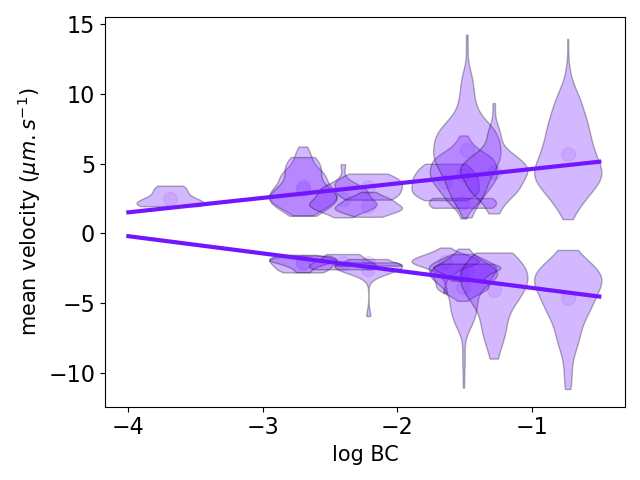

In [46]:
cmap = mpl.cm.get_cmap("rainbow")

plt.close('all')
high_bet = table_speeds_bet.loc[table_speeds_bet['normalized_betweenness']>0.005]

# select = table_bet.loc[table_bet['normalized_random_betweenness']>0.005]
# select = select.loc[select['speed']>0.1]

colors = ['blue','red','green','orange','purple','grey','pink','cyan']
# for i,unique_id in enumerate(select['unique_id'].unique()):
# selection = ['599_20201217', '809_20211012', '40_20201214',
#        '799_20211001',"139_20201214","907_20220321"]
selection = ['599_20201217']
# selection = ["907_20220321"]
ydata = "normalized_betweenness"
select1 = high_bet.loc[high_bet["speed"]>1]
select2 = high_bet.loc[high_bet["speed"]<-1]
# n_resamples = 1000
means = []

for i,unique_id in enumerate(selection):
    fig, ax = plt.subplots()
    for select in [select1,select2]:

        select_unique = select.loc[select['unique_id'].isin(selection)].copy()
        select_unique = select_unique.sort_values(ydata)
        select_unique = select.loc[select['unique_id']==unique_id]
        select_unique = select_unique.sort_values(ydata)
        mean = select_unique.groupby(ydata)['speed'].mean()
        x,y = mean.index,mean
        color = cmap((np.mean(select_unique['days_without'])/20))

        x = np.log(x)
        # ax.scatter(x,y,label=unique_id,color = colors[i],alpha = 0.1)
        # ax.set_xscale('log')
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.scatter(x,y,label=unique_id,color = color,alpha = 0.1)
        x0 = np.linspace(-4,-0.5,2)
        ax.plot(x0,np.array(x0)*a+b,color = color,alpha = 1)
        for tot_num_spores in select_unique[f"log_{ydata}"].unique():
            subselect = select_unique.loc[select_unique[f"log_{ydata}"]==tot_num_spores]
            day = subselect[f"log_{ydata}"].iloc[0]
            parts = ax.violinplot(subselect["speed"],[day]
                                  ,widths = 0.5,showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
                pc.set_edgecolor('black')
    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)
    
    # x,y,c = select_unique[ydata],select_unique['speed'],select_unique['days']
    # x = np.log(x)
    # X = sm.add_constant(x, prepend=False)
    # model = sm.OLS(y,X)
    # res = model.fit()
    # a,b = res.params[0],res.params[1]
    # ax.plot(x0,np.array(x0)*a+b,color = "black")
    # ax.set_ylim(-6,6)

    ax.set_xlabel('log BC')
    ax.set_ylabel('mean velocity ($\mu m.s^{-1}$)')
    # ax.set_yscale('symlog')
    
    plt.tight_layout()
    # plt.savefig(os.path.join(path_figure,'meanspeed_BC_uncropped.png'))
    # ax.legend()
# ax.set_ylim(-6,6)


plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.EPS'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.png'))
# plt.savefig(os.path.join(path_figure,'meanspeed_BC.png'))

In [63]:
def make_stat(x0):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = "grey", alpha = 0.01)
        return(a)
    return(statistic)

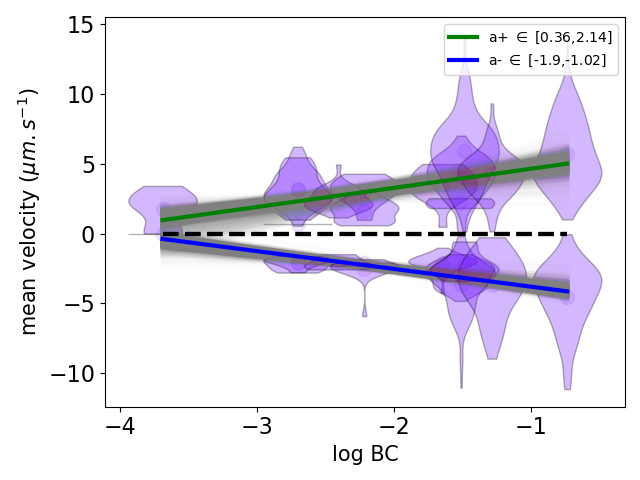

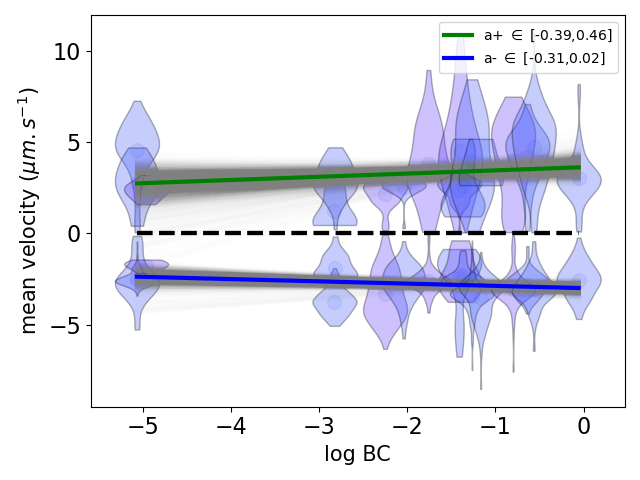

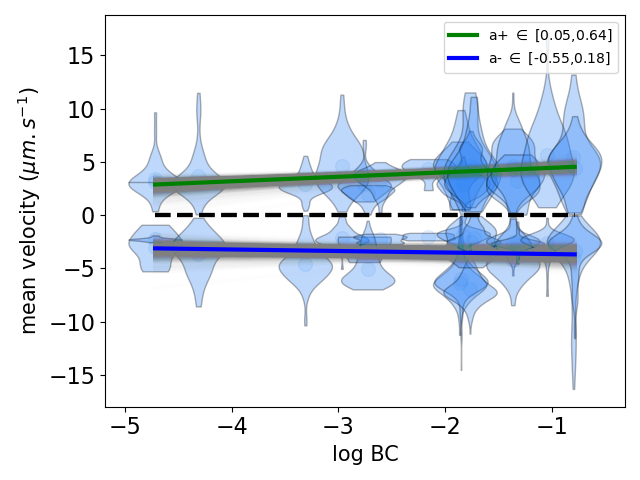

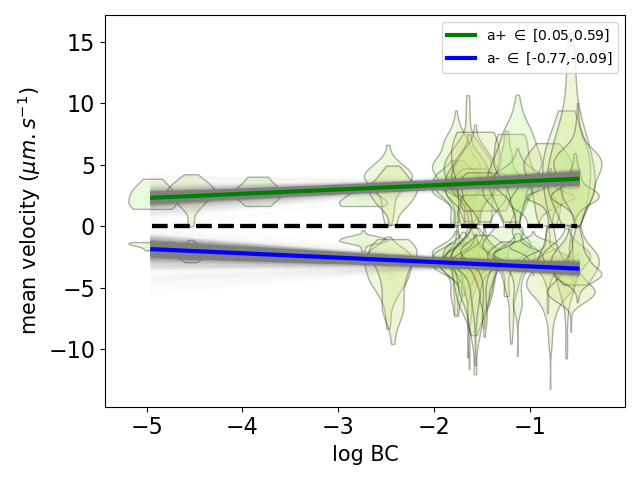

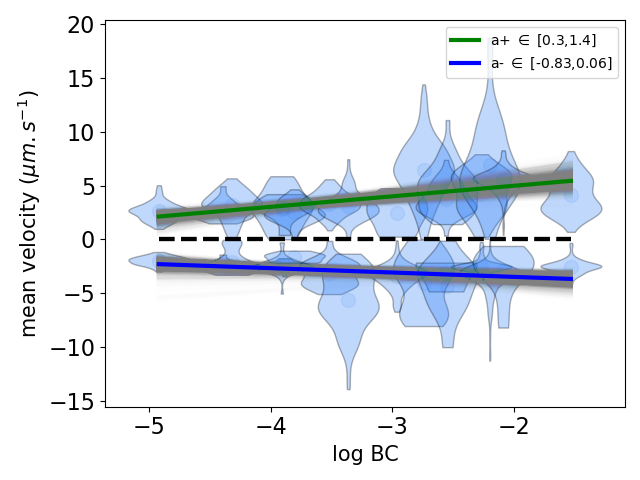

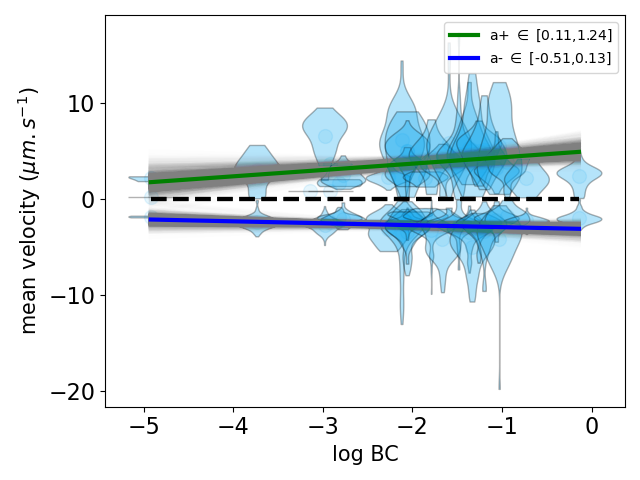

In [80]:
cmap = mpl.cm.get_cmap("rainbow")

plt.close('all')
high_bet = table_speeds_bet.loc[table_speeds_bet['normalized_betweenness']>0.005]

# select = table_bet.loc[table_bet['normalized_random_betweenness']>0.005]
# select = select.loc[select['speed']>0.1]

colors = ['blue','red','green','orange','purple','grey','pink','cyan']
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = ['599_20201217', '809_20211012', '40_20201214',
       '799_20211001',"139_20201214","907_20220321"]
# selection = ['599_20201217']
# selection = ["907_20220321"]
ydata = "normalized_betweenness"
select1 = high_bet.loc[high_bet["speed"]>=0]
select2 = high_bet.loc[high_bet["speed"]<=0]
# n_resamples = 1000
means = []
n_resamples = 1000
aps =  []
ams = []
for i,unique_id in enumerate(selection):
    fig, ax = plt.subplots()
    
    for k,select in enumerate([select1,select2]):

        select_unique = select.loc[select['unique_id'].isin(selection)].copy()
        select_unique = select_unique.sort_values(ydata)
        select_unique = select.loc[select['unique_id']==unique_id]
        select_unique = select_unique.sort_values(ydata)
        mean = select_unique.groupby(ydata)['speed'].mean()
        x,y = mean.index,mean
        color = cmap((np.mean(select_unique['days_without'])/20))

        x = np.log(x)
        # ax.scatter(x,y,label=unique_id,color = colors[i],alpha = 0.1)
        # ax.set_xscale('log')
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.scatter(x,y,color = color,alpha = 0.1)
        # x0 = np.linspace(-4,-0.5,2)
        # x0=x
        maxi = np.max(high_bet.loc[high_bet['unique_id']==unique_id][f"log_{ydata}"])
        mini = np.min(high_bet.loc[high_bet['unique_id']==unique_id][f"log_{ydata}"])
        x0 = np.linspace(mini,maxi,2)
        
        statistic = make_stat(x)
        data = np.array((x,y))
        
        ci = scipy.stats.bootstrap(data,statistic,
                                    vectorized = False,
                                    method="basic",
                                    n_resamples = n_resamples,
                                    paired= True).confidence_interval
        if k ==0:
            aps.append((a,ci))
        else:
            ams.append((a,ci))
        label = f'a{"+" if k == 0 else "-"} $\in$ [{round(ci.low,2)},{round(ci.high,2)}]'
        ax.plot(x0,0*x0,color = "black",alpha = 1,linestyle='--')
        color = 'green' if k == 0 else "blue"
        
        ax.plot(x0,np.array(x0)*a+b,color = color,alpha = 1,label = label)
        ax.legend()
        
        for tot_num_spores in select_unique[f"log_{ydata}"].unique():
            subselect = select_unique.loc[select_unique[f"log_{ydata}"]==tot_num_spores]
            day = subselect[f"log_{ydata}"].iloc[0]
            parts = ax.violinplot(subselect["speed"],[day]
                                  ,widths = 0.5,showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
                pc.set_edgecolor('black')
    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)

    ax.set_xlabel('log BC')
    ax.set_ylabel('mean velocity ($\mu m.s^{-1}$)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(path_figure, 'BCs',f'{unique_id}.png'))

# ax.set_ylim(-6,6)


plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.EPS'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.png'))
# plt.savefig(os.path.join(path_figure,'meanspeed_BC.png'))

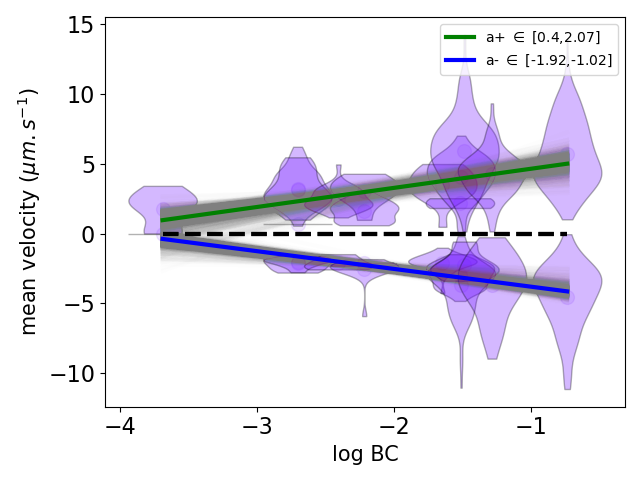

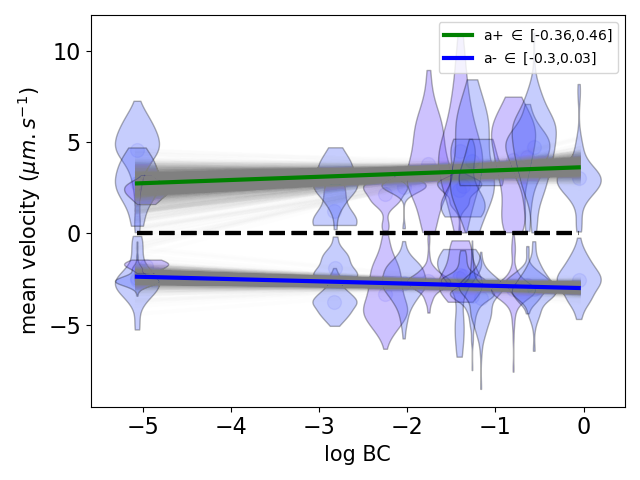

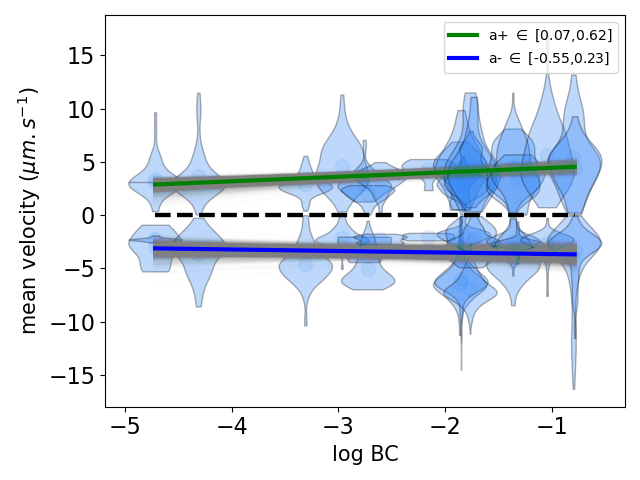

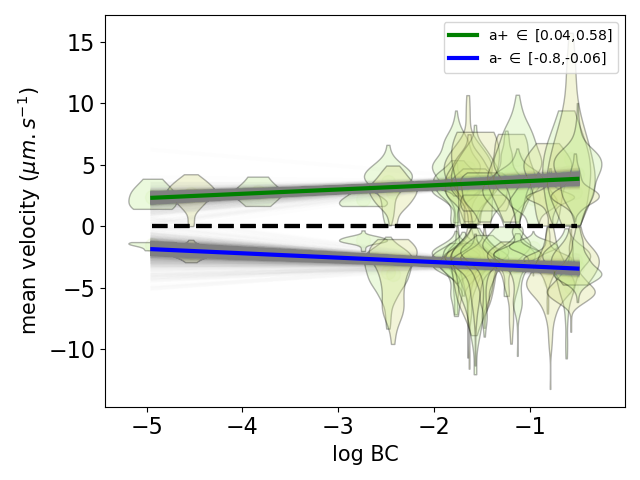

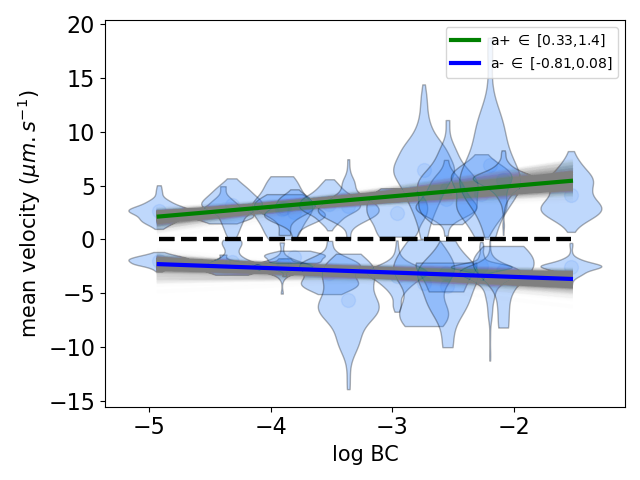

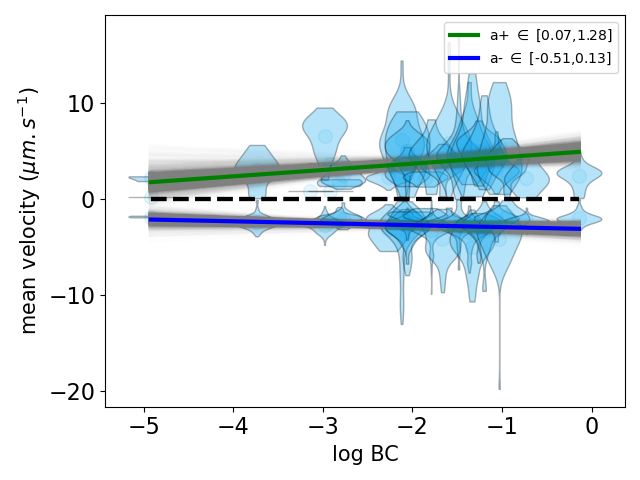

In [79]:
cmap = mpl.cm.get_cmap("rainbow")

plt.close('all')
high_bet = table_speeds_bet.loc[table_speeds_bet['normalized_random_betweenness']>0.005]

# select = table_bet.loc[table_bet['normalized_random_betweenness']>0.005]
# select = select.loc[select['speed']>0.1]

colors = ['blue','red','green','orange','purple','grey','pink','cyan']
# for i,unique_id in enumerate(select['unique_id'].unique()):
selection = ['599_20201217', '809_20211012', '40_20201214',
       '799_20211001',"139_20201214","907_20220321"]
# selection = ['599_20201217']
# selection = ["907_20220321"]
ydata = "normalized_random_betweenness"
select1 = high_bet.loc[high_bet["speed"]>=0]
select2 = high_bet.loc[high_bet["speed"]<=0]
# n_resamples = 1000
means = []
n_resamples = 1000
aps =  []
ams = []

for i,unique_id in enumerate(selection):
    fig, ax = plt.subplots()
    
    for k,select in enumerate([select1,select2]):

        select_unique = select.loc[select['unique_id'].isin(selection)].copy()
        select_unique = select_unique.sort_values(ydata)
        select_unique = select.loc[select['unique_id']==unique_id]
        select_unique = select_unique.sort_values(ydata)
        mean = select_unique.groupby(ydata)['speed'].mean()
        x,y = mean.index,mean
        color = cmap((np.mean(select_unique['days_without'])/20))

        x = np.log(x)
        # ax.scatter(x,y,label=unique_id,color = colors[i],alpha = 0.1)
        # ax.set_xscale('log')
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.scatter(x,y,color = color,alpha = 0.1)
        # x0 = np.linspace(-4,-0.5,2)
        # x0=x
        maxi = np.max(high_bet.loc[high_bet['unique_id']==unique_id][f"log_{ydata}"])
        mini = np.min(high_bet.loc[high_bet['unique_id']==unique_id][f"log_{ydata}"])
        x0 = np.linspace(mini,maxi,2)
        
        statistic = make_stat(x)
        data = np.array((x,y))
        
        ci = scipy.stats.bootstrap(data,statistic,
                                    vectorized = False,
                                    method="basic",
                                    n_resamples = n_resamples,
                                    paired= True).confidence_interval
        if k ==0:
            aps.append((a,ci))
        else:
            ams.append((a,ci))
        label = f'a{"+" if k == 0 else "-"} $\in$ [{round(ci.low,2)},{round(ci.high,2)}]'
        color = 'green' if k == 0 else "blue"
        ax.plot(x0,0*x0,color = "black",alpha = 1,linestyle='--')
        ax.plot(x0,np.array(x0)*a+b,color = color,alpha = 1,label = label)
        
        ax.legend()
        
        for tot_num_spores in select_unique[f"log_{ydata}"].unique():
            subselect = select_unique.loc[select_unique[f"log_{ydata}"]==tot_num_spores]
            day = subselect[f"log_{ydata}"].iloc[0]
            parts = ax.violinplot(subselect["speed"],[day]
                                  ,widths = 0.5,showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor(cmap(np.mean(subselect['days_without'])/20))
                pc.set_edgecolor('black')
    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)

    ax.set_xlabel('log BC')
    ax.set_ylabel('mean velocity ($\mu m.s^{-1}$)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(path_figure, 'RWBCs',f'{unique_id}.png'))

# ax.set_ylim(-6,6)


plt.tight_layout()
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.svg'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.EPS'))
# plt.savefig(os.path.join(path_figure,'Figure4Fmaxspeed.png'))
# plt.savefig(os.path.join(path_figure,'meanspeed_BC.png'))

In [86]:
days = []
for i,unique_id in enumerate(selection):
    select_unique = select.loc[select['unique_id'].isin(selection)].copy()
    select_unique = select_unique.sort_values(ydata)
    select_unique = select.loc[select['unique_id']==unique_id]
    day = (np.mean(select_unique['days_without']))
    days.append(day)

In [90]:
aps[0][1]

ConfidenceInterval(low=0.36242321910343867, high=2.142733769857857)

Text(0, 0.5, 'fit with betweenness centrality')

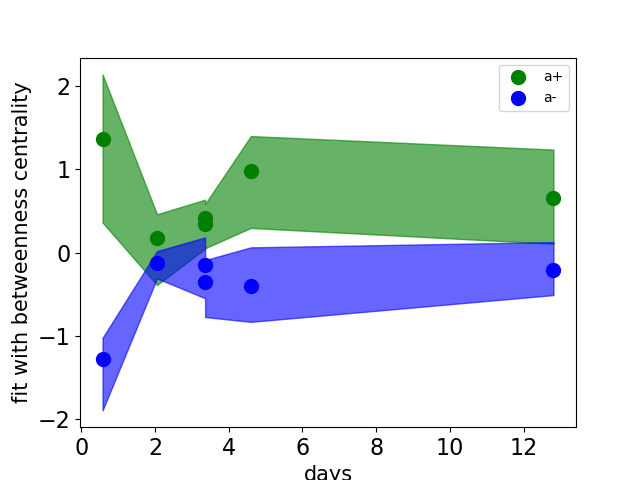

In [106]:
fig, ax = plt.subplots()
amsvalues = [c[0] for c in ams]
apsvalues = [c[0] for c in aps]
apsup = [c[1].high for c in aps]
apslow = [c[1].low for c in aps]
apsvalues = [x for _, x in sorted(zip(days, apsvalues))]

apsup = [x for _, x in sorted(zip(days, apsup))]
apslow = [x for _, x in sorted(zip(days, apslow))]
amsup = [c[1].high for c in ams]
amslow = [c[1].low for c in ams]
amsvalues = [x for _, x in sorted(zip(days, amsvalues))]

amsup = [x for _, x in sorted(zip(days, amsup))]
amslow = [x for _, x in sorted(zip(days, amslow))]
amsvalues = [x for _, x in sorted(zip(days, amsvalues))]

days = sorted(days)


ax.scatter(days,apsvalues,label = "a+",color = "green")
ax.fill_between(days, apslow, apsup,color="green",alpha = 0.6)
ax.scatter(days,amsvalues,label = "a-",color = "blue")
ax.fill_between(days, amslow, amsup,color="blue",alpha = 0.6)
ax.legend()
ax.set_xlabel("days")
ax.set_ylabel("fit with betweenness centrality")

In [100]:
ams

[(-1.2722472389497168,
  ConfidenceInterval(low=-1.8951030752455638, high=-1.0234374344155497)),
 (-0.12350776179827842,
  ConfidenceInterval(low=-0.30861876073105676, high=0.01875989851196813)),
 (-0.14376310469169856,
  ConfidenceInterval(low=-0.5473108411791983, high=0.18368516875739171)),
 (-0.3555621451598208,
  ConfidenceInterval(low=-0.7730709017497555, high=-0.08848850853370338)),
 (-0.4058631058016967,
  ConfidenceInterval(low=-0.8312668047217298, high=0.064379662028615)),
 (-0.2027961042908383,
  ConfidenceInterval(low=-0.5089510315793476, high=0.1269742277475751))]